In [9]:
import pandas as pd
import numpy as np
import keras as K
import keras.layers as L
import keras.optimizers as O


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [10]:
# Read the CSV file into a DataFrame
df = pd.read_csv('Thesisdataset.csv', parse_dates=['UTC'], date_format='%Y-%m-%d %H:%M:%S%z')

In [11]:
# Set 'UTC' column as the index
df.set_index('UTC', inplace=True)

In [15]:
# Creating cyclical features
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['dayofweek'] = df.index.dayofweek

# Transforming the features using sine and cosine
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

# Dropping the original columns used for transformation
df.drop(columns=['hour', 'day', 'month', 'dayofweek'], inplace=True)

In [16]:
# Splitting the data into features (X) and target (y)
X = df[['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos','Irr', 'PrdNorm']]
y = df['Irr', 'PrdNorm']

# Splitting the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

KeyError: ('Irr', 'PrdNorm')

In [17]:
# Parameters for the RNN
n_back = 24  # past 24 hours
n_next = 1   # next 1 hour

In [18]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


NameError: name 'X_train' is not defined

In [6]:
# Prepare data for RNN
n_back = 24
X_train_seq = np.zeros((len(X_train) - n_back, n_back, X_train.shape[1]))
y_train_seq = np.zeros(len(X_train) - n_back)

for i in range(len(X_train) - n_back):
    X_train_seq[i] = X_train.values[i:i + n_back]
    y_train_seq[i] = y_train.values[i + n_back]

X_test_seq = np.zeros((len(X_test) - n_back, n_back, X_test.shape[1]))
y_test_seq = np.zeros(len(X_test) - n_back)

for i in range(len(X_test) - n_back):
    X_test_seq[i] = X_test.values[i:i + n_back]
    y_test_seq[i] = y_test.values[i + n_back]

NameError: name 'X_train' is not defined

In [7]:
# Define the RNN model with LSTM layers
rnn_model = K.Sequential()
rnn_model.add(L.Input( shape=(X_train_seq.shape[1], X_train_seq.shape[2])) )
fw_layer = L.LSTM(64, activation='relu', dropout=0.00, return_sequences=True)
bw_layer = L.LSTM(64, activation='relu', dropout=0.00, return_sequences=True, go_backwards=True)
rnn_model.add(L.Bidirectional(fw_layer, backward_layer=bw_layer))

rnn_model.add(L.TimeDistributed(L.Dense(64, activation='relu')))
rnn_model.add(L.TimeDistributed(L.Dense(32, activation='relu')))
rnn_model.add(L.TimeDistributed(L.Dense(16, activation='relu')))

rnn_model.add(L.Flatten())

#rnn_model.add(L.Dropout(0.01))
rnn_model.add(L.Dense(64, use_bias=False))
rnn_model.add(L.BatchNormalization())
rnn_model.add(L.ReLU())

rnn_model.add(L.Dense(32, use_bias=False))
rnn_model.add(L.BatchNormalization())
rnn_model.add(L.ReLU())

rnn_model.add(L.Dense(16, use_bias=False))
rnn_model.add(L.BatchNormalization())
rnn_model.add(L.ReLU())

rnn_model.add(L.Dense(2, use_bias=True))
rnn_model.add(L.ReLU())

rnn_model.summary()



NameError: name 'X_train_seq' is not defined

In [107]:
# Compile the model
opt = O.Adam(learning_rate=0.0002)
rnn_model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])

# Callbacks for early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


In [108]:
# Train the model
h = rnn_model.fit(
    X_train_seq, y_train_seq, 
    epochs=100,
    batch_size=64,
    validation_data=(X_test_seq, y_test_seq), 
    callbacks=[early_stop, lr_scheduler])

Epoch 1/100
700/700 [==============================] - 15s 19ms/step - loss: 0.0548 - mae: 0.1298 - val_loss: 0.0120 - val_mae: 0.0566 - lr: 2.0000e-04
Epoch 2/100
700/700 [==============================] - 14s 19ms/step - loss: 0.0145 - mae: 0.0666 - val_loss: 0.0081 - val_mae: 0.0461 - lr: 2.0000e-04
Epoch 3/100
700/700 [==============================] - 14s 19ms/step - loss: 0.0116 - mae: 0.0589 - val_loss: 0.0072 - val_mae: 0.0438 - lr: 2.0000e-04
Epoch 4/100
700/700 [==============================] - 13s 19ms/step - loss: 0.0092 - mae: 0.0521 - val_loss: 0.0059 - val_mae: 0.0396 - lr: 2.0000e-04
Epoch 5/100
700/700 [==============================] - 14s 19ms/step - loss: 0.0083 - mae: 0.0496 - val_loss: 0.0059 - val_mae: 0.0401 - lr: 2.0000e-04
Epoch 6/100
700/700 [==============================] - 15s 21ms/step - loss: 0.0077 - mae: 0.0474 - val_loss: 0.0052 - val_mae: 0.0364 - lr: 2.0000e-04
Epoch 7/100
700/700 [==============================] - 14s 21ms/step - loss: 0.0066 - ma

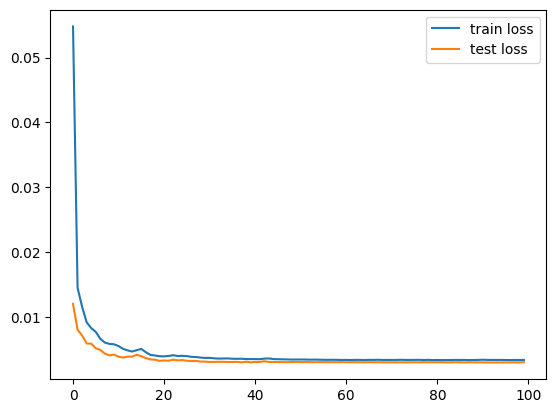

In [109]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['train loss', 'test loss'])
plt.show()




350/350 [==============================] - 1s 3ms/step


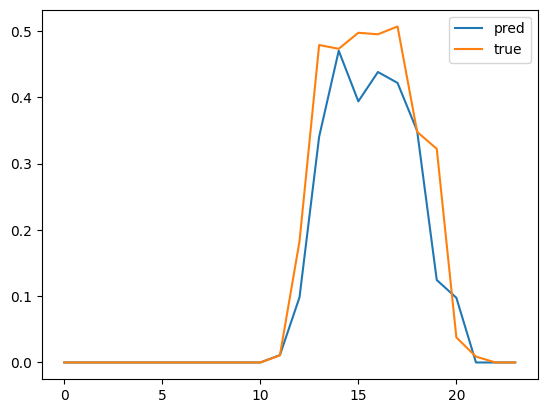

In [117]:
y_pred_rnn = rnn_model.predict(X_test_seq)
y_pred_rnn = y_pred_rnn.ravel()



plt.figure()
plt.plot(y_pred_rnn[37+24:37+48])
plt.plot(y_test_seq[37+24:37+48])
plt.legend(['pred', 'true'])
plt.show()


In [114]:
# Calculate metrics
mape_rnn = adjusted_mape(y_test_hour, y_pred_hour)
smape_rnn = np.mean(2 * np.abs(y_pred_hour - y_test_hour) / (np.abs(y_pred_hour) + np.abs(y_test_hour))) * 100
mbe_rnn = np.mean(y_pred_hour - y_test_hour)  # Mean Bias Error
mae_rnn = mean_absolute_error(y_test_hour, y_pred_hour)
rmse_rnn = np.sqrt(mean_squared_error(y_test_hour, y_pred_hour))
r2_rnn = r2_score(y_test_hour, y_pred_hour)

# Print the evaluation results for each hour

print(f"  Adjusted MAPE: {mape_rnn:.2f}%")
print(f"  SMAPE: {smape_rnn:.2f}%")
print(f"  MBE: {mbe_rnn:.2f}")
print(f"  MAE: {mae_rnn:.2f}")
print(f"  RMSE: {rmse_rnn:.2f}")
print(f"  R²: {r2_rnn:.2f}\n")

  Adjusted MAPE: 9158.22%
  SMAPE: nan%
  MBE: -0.00
  MAE: 0.03
  RMSE: 0.06
  R²: 0.94



/var/folders/jt/kyx6hq5j06xckkk40t7gff180000gn/T/ipykernel_23622/1698621086.py:3: RuntimeWarning: invalid value encountered in divide
  smape_rnn = np.mean(2 * np.abs(y_pred_hour - y_test_hour) / (np.abs(y_pred_hour) + np.abs(y_test_hour))) * 100


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

# Read the CSV file into a DataFrame
df = pd.read_csv('Thesisdataset.csv', parse_dates=['UTC'], date_format='%Y-%m-%d %H:%M:%S%z')
df.set_index('UTC', inplace=True)

# Creating cyclical features
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['dayofweek'] = df.index.dayofweek
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df.drop(columns=['hour', 'day', 'month', 'dayofweek'], inplace=True)

# Splitting the data into features (X) and target (y)
X = df[['Irr', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos']]
y = df['PrdNorm']

# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Splitting the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)



In [17]:
# Prepare data for RNN
n_back = 24  # Use past 24 hours for predictions
X_train_seq = np.array([X_train[i:i + n_back] for i in range(len(X_train) - n_back)])
y_train_seq = np.array([y_train[i + n_back] for i in range(len(y_train) - n_back)])
X_test_seq = np.array([X_test[i:i + n_back] for i in range(len(X_test) - n_back)])
y_test_seq = np.array([y_test[i + n_back] for i in range(len(y_test) - n_back)])



In [18]:

# Reshape input data to 3D for RNN: (samples, time_steps, features)
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], X_train_seq.shape[2]))
X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], X_test_seq.shape[1], X_test_seq.shape[2]))


In [19]:
# Define the RNN model with LSTM layers
rnn_model = Sequential()
rnn_model.add(LSTM(100, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
rnn_model.add(Dropout(0.3))  # Increased dropout
rnn_model.add(LSTM(50, activation='relu'))
rnn_model.add(Dropout(0.3))  # Increased dropout
rnn_model.add(Dense(64, activation='relu'))
rnn_model.add(Dense(32, activation='relu'))
rnn_model.add(Dense(1))

# Compile the model
opt = Adam(learning_rate=0.0001)
rnn_model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])

# Callbacks for early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)



In [21]:
# Train the model with callbacks
rnn_model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=16, validation_data=(X_test_seq, y_test_seq), callbacks=[early_stop, lr_scheduler])



Epoch 1/10
2799/2799 [==============================] - 32s 11ms/step - loss: 0.0747 - mae: 0.2252 - val_loss: 0.0758 - val_mae: 0.2174 - lr: 1.0000e-04
Epoch 2/10
2799/2799 [==============================] - 31s 11ms/step - loss: 0.0745 - mae: 0.2256 - val_loss: 0.0758 - val_mae: 0.2172 - lr: 1.0000e-04
Epoch 3/10
2799/2799 [==============================] - 32s 11ms/step - loss: 0.0744 - mae: 0.2256 - val_loss: 0.0751 - val_mae: 0.2227 - lr: 1.0000e-04
Epoch 4/10
2799/2799 [==============================] - 32s 11ms/step - loss: 0.0745 - mae: 0.2256 - val_loss: 0.0750 - val_mae: 0.2241 - lr: 1.0000e-04
Epoch 5/10
2799/2799 [==============================] - 31s 11ms/step - loss: 0.0744 - mae: 0.2258 - val_loss: 0.0751 - val_mae: 0.2238 - lr: 1.0000e-04
Epoch 6/10
2799/2799 [==============================] - 31s 11ms/step - loss: 0.0744 - mae: 0.2258 - val_loss: 0.0752 - val_mae: 0.2215 - lr: 1.0000e-04
Epoch 7/10
2799/2799 [==============================] - 32s 11ms/step - loss: 0.07

In [22]:
# Make predictions on the test set
y_pred_rnn = rnn_model.predict(X_test_seq)

# Flatten the predictions
y_pred_rnn = y_pred_rnn.ravel()

# Inverse transform the predictions and actual values to original scale
y_test_inverse = scaler_y.inverse_transform(y_test_seq)
y_pred_inverse = scaler_y.inverse_transform(y_pred_rnn.reshape(-1, 1))

# Evaluate the RNN model
mape_rnn = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)
smape_rnn = np.mean(2 * np.abs(y_pred_inverse - y_test_inverse) / (np.abs(y_pred_inverse) + np.abs(y_test_inverse))) * 100
mbe_rnn = np.mean(y_pred_inverse - y_test_inverse)  # Mean Bias Error
mae_rnn = mean_absolute_error(y_test_inverse, y_pred_inverse)
rmse_rnn = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
r2_rnn = r2_score(y_test_inverse, y_pred_inverse)

# Print the evaluation results
print(f"RNN Adjusted MAPE: {mape_rnn:.2f}%")
print(f"RNN SMAPE: {smape_rnn:.2f}%")
print(f"RNN MBE: {mbe_rnn:.2f}")
print(f"RNN MAE: {mae_rnn:.2f}")
print(f"RNN RMSE: {rmse_rnn:.2f}")
print(f"RNN R²: {r2_rnn:.2f}")

350/350 [==============================] - 2s 4ms/step
RNN Adjusted MAPE: 341635858373412.44%
RNN SMAPE: 149.19%
RNN MBE: -0.00
RNN MAE: 0.20
RNN RMSE: 0.25
RNN R²: -0.00
